## Reading Git Final Project

In [1]:
import os
import subprocess
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.types import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
gcs_folder = 'gs://msca-bdp-data-open/final_project_git'

#### Check data size in GCS

In [9]:
cmd = 'gsutil du -s -h ' + gcs_folder

p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
for line in p.stdout.readlines():
    print (f'Total directory size: {line}')
    
retval = p.wait() # Wait for the child process to terminate.

Total directory size: 1.36 TiB     gs://msca-bdp-data-open/final_project_git



### Read Git data from GCS

#### Languages
Programming languages by repository as reported by GitHub's https://developer.github.com/v3/repos/#list-languages API

In [4]:
%%time   
    
df_languages = spark.read.parquet(os.path.join(gcs_folder, 'languages'))
print(f'Records read from dataframe *languages*: {df_languages.count():,.0f}')

Records read from dataframe *languages*: 3,325,634
CPU times: user 10.2 ms, sys: 3.46 ms, total: 13.7 ms
Wall time: 11 s


In [10]:
df_languages.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)



#### Licenses
Open source license SPDX code for each repository as detected by https://developer.github.com/v3/licenses/

In [5]:
%%time   
    
df_licenses = spark.read.parquet(os.path.join(gcs_folder, 'licenses'))
print(f'Records read from dataframe *licenses*: {df_licenses.count():,.0f}')

Records read from dataframe *licenses*: 3,325,634
CPU times: user 1.61 ms, sys: 3.49 ms, total: 5.1 ms
Wall time: 1.19 s


In [11]:
df_licenses.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)



#### Commits
Unique Git commits from open source repositories on GitHub, pre-grouped by repositories they appear in.

In [8]:
%%time   
    
df_commits = spark.read.parquet(os.path.join(gcs_folder, 'commits'))
print(f'Records read from dataframe *commits*: {df_commits.count():,.0f}')

Records read from dataframe *commits*: 265,419,190
CPU times: user 187 ms, sys: 37.6 ms, total: 225 ms
Wall time: 1min 5s


In [22]:
df_commits.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (nullable = true)
 |    |-- element: struct (contains

#### Contents
Unique file contents of text files under 1 MiB on the HEAD branch.  
Can be joined to `files` dataset using the id columns to identify the repository and file path.

In [4]:
%%time   
    
df_contents = spark.read.parquet(os.path.join(gcs_folder, 'contents'))
print(f'Records read from dataframe *commits*: {df_contents.count():,.0f}')

Records read from dataframe *commits*: 281,191,977
CPU times: user 453 ms, sys: 101 ms, total: 554 ms
Wall time: 2min 34s


In [12]:
df_contents.printSchema()

root
 |-- id: string (nullable = true)
 |-- size: long (nullable = true)
 |-- content: string (nullable = true)
 |-- binary: boolean (nullable = true)
 |-- copies: long (nullable = true)



#### Files
File metadata for all files at HEAD.  
Join with `contents` dataset on id columns to search text.

In [8]:
%%time   
    
df_files = spark.read.parquet(os.path.join(gcs_folder, 'files'))
print(f'Records read from dataframe *files*: {df_files.count():,.0f}')

Records read from dataframe *files*: 2,309,424,945
CPU times: user 15.7 ms, sys: 4.28 ms, total: 20 ms
Wall time: 5.7 s


In [14]:
df_files.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- ref: string (nullable = true)
 |-- path: string (nullable = true)
 |-- mode: long (nullable = true)
 |-- id: string (nullable = true)
 |-- symlink_target: string (nullable = true)



In [24]:
df_languages.show(5)

+-------------------+------------+
|          repo_name|    language|
+-------------------+------------+
|  lemi136/puntovent|   [{C, 80}]|
|     taxigps/nctool| [{C, 4461}]|
|        ahy1/strbuf| [{C, 5573}]|
|nleiten/mod_rpaf-ng|[{C, 30330}]|
|kmcallister/alameda|[{C, 17077}]|
+-------------------+------------+
only showing top 5 rows



### Languages EDA

In [12]:
from pyspark.sql.functions import explode, col

df_lang_exp = df_languages.select(
    col("repo_name"),
    explode(col("language")).alias("language_struct")  
)

df_lang_flat = df_lang_exp.select(
    col("repo_name"),
    col("language_struct.name").alias("language_name"),
    col("language_struct.bytes").alias("language_bytes")
)

In [13]:
df_lang_flat.show(5)

+-------------------+-------------+--------------+
|          repo_name|language_name|language_bytes|
+-------------------+-------------+--------------+
|  lemi136/puntovent|            C|            80|
|     taxigps/nctool|            C|          4461|
|        ahy1/strbuf|            C|          5573|
|nleiten/mod_rpaf-ng|            C|         30330|
|kmcallister/alameda|            C|         17077|
+-------------------+-------------+--------------+
only showing top 5 rows



In [12]:
from pyspark.sql.functions import col, sum

df_lang_flat.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_lang_flat.columns]).show()

+---------+-------------+--------------+
|repo_name|language_name|language_bytes|
+---------+-------------+--------------+
|        0|            0|             0|
+---------+-------------+--------------+



In [14]:
df_lang_flat.groupBy(df_lang_flat.columns).count().filter(col("count") > 1).show()

+---------+-------------+--------------+-----+
|repo_name|language_name|language_bytes|count|
+---------+-------------+--------------+-----+
+---------+-------------+--------------+-----+



In [16]:
df_lang_sample = df_lang_flat.sample(withReplacement=False, fraction=0.05, seed=42)

In [69]:
df_lang_sample.write.mode("overwrite").parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/Final Project/lang_sample.parquet")

### License EDA

In [33]:
df_licenses.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_licenses.columns]).show(5)

+---------+-------+
|repo_name|license|
+---------+-------+
|        0|      0|
+---------+-------+



In [34]:
df_licenses.groupBy(df_licenses.columns).count().filter(col("count") > 1).show(5)

+---------+-------+-----+
|repo_name|license|count|
+---------+-------+-----+
+---------+-------+-----+



In [35]:
df_license_sample = df_licenses.sample(withReplacement=False, fraction=0.05, seed=42)

In [71]:
df_license_sample.write.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/Final Project/license_sample.parquet")

### Commits EDA

In [10]:
from pyspark.sql.functions import col, explode

df_expanded = df_commits.select(
    col("author.name").alias("author_name"),
    col("author.email").alias("author_email"),
    col("author.time_sec").alias("author_time_sec"),
    col("committer.name").alias("committer_name"),
    col("committer.email").alias("committer_email"),
    col("commit"),
    col("subject"),
    col("message"),
    explode(col("repo_name")).alias("repo_name") 
)

# Removing rows with null values
df_cleaned = df_expanded.dropna()

# Removing duplicates
df_final = df_cleaned.dropDuplicates()

df_final.show(5)

+--------------------+--------------------+---------------+--------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|         author_name|        author_email|author_time_sec|committer_name|     committer_email|              commit|             subject|             message|          repo_name|
+--------------------+--------------------+---------------+--------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|              zenril|e274eeff768c63960...|     1438918563|        zenril|e274eeff768c63960...|f649205b6894e5936...|    Update README.md|    Update README.md|    zenril/AMRouter|
|        Sam Hemelryk|f16bed56189e249fe...|     1377208848|  Sam Hemelryk|f16bed56189e249fe...|22c943b33b2ee2553...|MDL-41213 filepic...|MDL-41213 filepic...|  Raeghin/elearning|
|          Tim Penhey|5ee0edb9e2229c083...|     1408589918|    Tim Penhey|5ee0edb9e2229c083...|c75ea9072e

In [11]:
df_commits_sample = df_final.sample(withReplacement=False, fraction=0.05, seed=42)
df_commits_sample.write.mode("overwrite").parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/Final Project/commits_sample.parquet")

#### Contents EDA

In [5]:
df_contents_clean = df_contents.dropna()
df_contents_clean = df_contents_clean.dropDuplicates()

In [ ]:
df_content_sample = df_contents_clean.sample(withReplacement=False, fraction=0.05, seed=42)
df_content_sample.write.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/Final Project/content_sample.parquet")

#### Files EDA

In [27]:
df_files.show(8)

+--------------------+-----------------+--------------------+-----+--------------------+--------------+
|           repo_name|              ref|                path| mode|                  id|symlink_target|
+--------------------+-----------------+--------------------+-----+--------------------+--------------+
|    enzbang/diouzhtu|refs/heads/master|gwiad_wiki_servic...|33261|49365044eed287691...|          NULL|
|TheMrNomis/Latex-...|refs/heads/master|             LFM.php|33261|ef8cb78feed7f2111...|          NULL|
|TheMrNomis/Latex-...|refs/heads/master|PHP/LatexFlavored...|33261|d989ce59652f57efa...|          NULL|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/EUExJPu...|33261|85268b90caa19efa2...|          NULL|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/uexJPus...|33261|e1623bb9d8dc7db60...|          NULL|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/EUExJPu...|33261|28a191eb0791ad2b0...|          NULL|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/EUExJPu...|332

In [ ]:
df_files_clean = df_files.drop("symlink_target")
df_files_clean = df_files.dropna()
df_files_clean = df_files_clean.dropDuplicates()

In [ ]:
df_files_sample = df_files_clean.sample(withReplacement=False, fraction=0.05, seed=42)
df_files_sample.write.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/Final Project/files_sample.parquet")

#### What is the timeline of the data?  Do you see significant peaks and valleys?

In [49]:
from pyspark.sql.functions import col, from_unixtime, year, month, dayofmonth

df_commits = df_commits.withColumn("timestamp", from_unixtime(col("author.time_sec")))
df_commits = df_commits.withColumn("year", year(col("timestamp")))

In [56]:
from pyspark.sql.functions import min, max

df_commits.select(min("year").alias("Earliest Year"), max("year").alias("Latest Year")).show()

+-------------+-----------+
|Earliest Year|Latest Year|
+-------------+-----------+
|         1970|       2245|
+-------------+-----------+



The data starts from 1970 and goes till 2245

In [62]:
df_commits_filtered = df_commits.filter((col("year") >= 2000) & (col("year") <= 2020))

In [51]:
commits_by_year = df_commits_filtered.groupBy("year").count()
commits_by_year = commits_by_year.orderBy("year")

#### Do you see any outliers?  Remove obvious outliers before plotting the timeline

In [64]:
q1 = commits_by_year.approxQuantile("count", [0.25], 0.01)[0]
q3 = commits_by_year.approxQuantile("count", [0.75], 0.01)[0]

iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = commits_by_year.filter((col("count") < lower_bound) | (col("count") > upper_bound))
outliers.show()

+----+-----+
|year|count|
+----+-----+
+----+-----+



no outliers present in the chunk of data taken

#### Do you see any spikes?  Are these spikes caused by real activities / events?

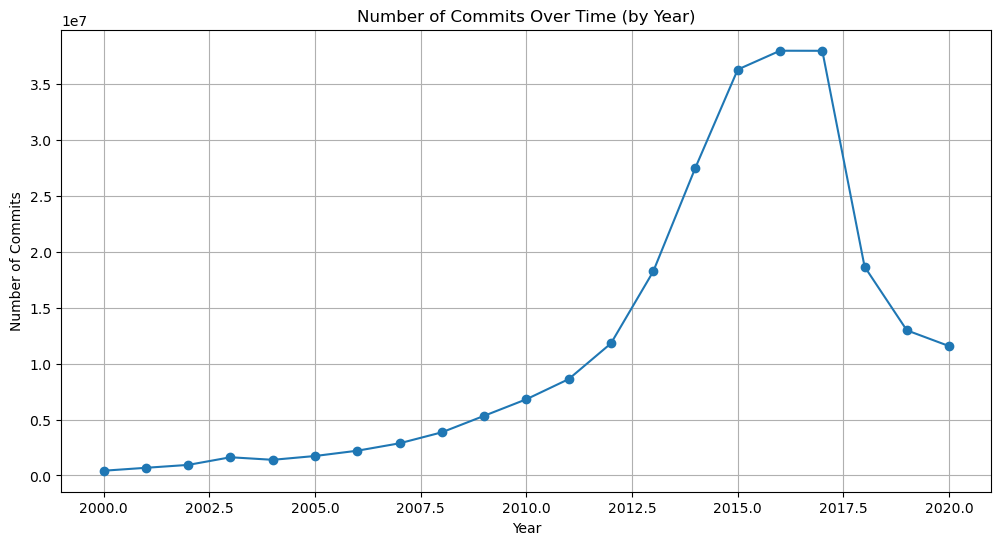

In [52]:
pdf = commits_by_year.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pdf["year"], pdf["count"], marker="o")
plt.title("Number of Commits Over Time (by Year)")
plt.xlabel("Year")
plt.ylabel("Number of Commits")
plt.grid(True)
plt.show()

I took a chunk of data to view seasonality from 2000-2020 and observed that it starts rising from 2012 and reachest its peak in 2016 and then sharply drops after that.

Steady Growth (2000–2014):
The number of commits steadily increased from ~425K (2000) to ~27.5M (2014).
The sharpest increase happened after 2010, which aligns with GitHub's rapid adoption and the overall rise in open-source development.
The peak growth was between 2012–2015, showing an almost exponential rise.

Peak Activity (2015–2016):
2015 (36.3M commits) and 2016 (37.9M commits) were the highest activity years.
2017 maintained a similar level, indicating that GitHub usage was stable at its peak.

Sharp Decline After 2017:
2018 saw a significant drop (from ~37.9M to ~18.7M commits).
The downward trend continued in 2019 (12.9M commits).

Possible Reasons for the Drop After 2017
Data collection gaps: Some repositories or commits might be missing in later years.
Changes in GitHub activity: Developers might be using fewer but more refined commits.
Private repositories growth: More companies using private repositories might result in fewer public commits.
Shift in coding practices: The rise of CI/CD and automated workflows might have changed how commits are logged.

#### Do you see any data collection gaps?

In [60]:
from pyspark.sql.functions import count

commits_per_year = df_commits_filtered.groupBy("year").agg(count("*").alias("commit_count"))
commits_per_year = commits_per_year.orderBy("year")
commits_per_year.show(20)  

+----+------------+
|year|commit_count|
+----+------------+
|2000|      424985|
|2001|      686681|
|2002|      945741|
|2003|     1629028|
|2004|     1400224|
|2005|     1740799|
|2006|     2214206|
|2007|     2877055|
|2008|     3858955|
|2009|     5333641|
|2010|     6815212|
|2011|     8615003|
|2012|    11809031|
|2013|    18237689|
|2014|    27534680|
|2015|    36295258|
|2016|    37976755|
|2017|    37969686|
|2018|    18668664|
|2019|    12976504|
+----+------------+
only showing top 20 rows



There is a noticeable dip in commit activity from 2003 (1,629,028) to 2004 (1,400,224), followed by a steady increase in subsequent years. However, a sharp decline is observed after 2017, with 2018 seeing a significant drop from approximately 37.9 million commits to around 18.7 million, and the downward trend continuing into 2019, with only 12.9 million commits recorded. This suggests a potential decrease in overall activity or could point to data inconsistencies during this period.

#### What are the most popular programming languages on GitHub?

In [17]:
from pyspark.sql.functions import sum

df_most_used = df_lang_sample.groupBy("language_name").agg(sum("language_bytes").alias("total_bytes"))

In [18]:
df_most_used.orderBy(col("total_bytes").desc()).show(10)

+-------------+------------+
|language_name| total_bytes|
+-------------+------------+
|            C|297795085381|
|   JavaScript| 59480577944|
|          C++| 28727585889|
|          PHP| 25773881121|
|         HTML| 17404356519|
|         Java| 15632650874|
|       Python|  9294181841|
|          CSS|  7627597009|
|     Assembly|  6612351939|
|           C#|  5828881159|
+-------------+------------+
only showing top 10 rows



#### Did the trend of most popular programming languages change over time?

In [19]:
from pyspark.sql.functions import col, expr

df_commits = df_commits.withColumn("repo_name", expr("repo_name[0]"))

In [20]:
from pyspark.sql.functions import from_unixtime, year

df_commits_date = df_commits.select(
    col("repo_name"),
    col("author.date.seconds").alias("timestamp")
)

df_commits_date = df_commits_date.withColumn("year", year(from_unixtime(col("timestamp"))))

In [21]:
df_lang_time = df_lang_flat.join(df_commits_date, on="repo_name", how="inner")

In [22]:
from pyspark.sql.functions import from_unixtime, to_date

df_lang_time = df_lang_time.withColumn("date", to_date(from_unixtime("timestamp")))

In [32]:
df_lang_time.show(5)

+--------------------+-------------+--------------+----------+----+----------+
|           repo_name|language_name|language_bytes| timestamp|year|      date|
+--------------------+-------------+--------------+----------+----+----------+
|MadCat34/zend-esc...|          PHP|         27672|1323443117|2011|2011-12-09|
|pscedu/slash2-stable|         Yacc|         31912|1303924643|2011|2011-04-27|
|pscedu/slash2-stable|         XSLT|          9363|1303924643|2011|2011-04-27|
|pscedu/slash2-stable|        Shell|        705302|1303924643|2011|2011-04-27|
|pscedu/slash2-stable|         Roff|        404427|1303924643|2011|2011-04-27|
+--------------------+-------------+--------------+----------+----+----------+
only showing top 5 rows



In [36]:
df_lang_time.filter(F.col("year").isNull()).show(5)

+-------------+-------------+--------------+---------+----+----+
|    repo_name|language_name|language_bytes|timestamp|year|date|
+-------------+-------------+--------------+---------+----+----+
|pawohl/studip|         XSLT|        187551|     NULL|NULL|NULL|
|pawohl/studip|       Smarty|         51991|     NULL|NULL|NULL|
|pawohl/studip|        Shell|          1589|     NULL|NULL|NULL|
|pawohl/studip|         Ruby|          1431|     NULL|NULL|NULL|
|pawohl/studip|          PHP|      11086274|     NULL|NULL|NULL|
+-------------+-------------+--------------+---------+----+----+
only showing top 5 rows



In [23]:
df_lang_time_clean = df_lang_time.filter(F.col("year").isNotNull())

In [24]:
df_lang_time_clean.filter(F.col("year").isNull()).show(5)

+---------+-------------+--------------+---------+----+----+
|repo_name|language_name|language_bytes|timestamp|year|date|
+---------+-------------+--------------+---------+----+----+
+---------+-------------+--------------+---------+----+----+



In [25]:
df_lang_time_sample = df_lang_time_clean.sample(withReplacement=False, fraction=0.05, seed=42)

In [28]:
from pyspark.sql import functions as F

language_trends = df_lang_time_sample.groupBy("year", "language_name").count()
language_trends = language_trends.orderBy("year", F.desc("count"))

In [29]:
language_trends.show(5)

+----+-------------+-----+
|year|language_name|count|
+----+-------------+-----+
|1970|         HTML|   29|
|1970|        Shell|   29|
|1970|       Racket|   26|
|1970|         Ruby|   24|
|1970|      Arduino|   23|
+----+-------------+-----+
only showing top 5 rows



In [30]:
df_lang_flat.write.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/lang_flat.parquet")
df_lang_sample.write.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/lang_sample.parquet")
df_lang_time.write.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/lang_time.parquet")
df_lang_time_sample.write.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/lang_time_sample.parquet")

### What is the distribution of licenses across GitHub repositories?

In [36]:
license_distribution = df_license_sample.groupBy("license").count()
license_distribution = license_distribution.orderBy(F.desc("count"))

In [37]:
license_distribution.show(5)

+------------+-----+
|     license|count|
+------------+-----+
|         mit|85030|
|  apache-2.0|24866|
|     gpl-2.0|17094|
|     gpl-3.0|16910|
|bsd-3-clause| 7464|
+------------+-----+
only showing top 5 rows



#### Any certain programming languages that are more likely to be associated with a particular license?

In [38]:
df_lang_license = df_lang_sample.join(df_license_sample, "repo_name", "inner")

In [42]:
language_license_distribution = df_lang_license.groupBy("language_name", "license").count()
language_license_distribution = language_license_distribution.orderBy(F.desc("count"))

In [43]:
language_license_distribution.show(10)

+-------------+----------+-----+
|language_name|   license|count|
+-------------+----------+-----+
|   JavaScript|       mit| 1702|
|          CSS|       mit| 1131|
|         HTML|       mit| 1033|
|         Ruby|       mit|  660|
|        Shell|       mit|  640|
|       Python|       mit|  507|
|          PHP|       mit|  404|
|         Java|apache-2.0|  343|
|   JavaScript|apache-2.0|  322|
|         HTML|apache-2.0|  311|
+-------------+----------+-----+
only showing top 10 rows



In [44]:
df_lang_license.write.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/lang_license.parquet")